In [1]:
import torch
import torchvision
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage import io
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
class my_net(nn.Module):
    def __init__(self, num_features):
        super(my_net, self).__init__()
        self.conv_stack = nn.Sequential(
            # Assume each feature is treated as a separate channel
            nn.Conv2d(in_channels=num_features, out_channels=10, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(),
            # Further convolutions might need to be adjusted depending on the input size and desired architecture
            nn.Conv2d(in_channels=10, out_channels=30, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=30, out_channels=50, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=50, out_channels=70, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(70, 1000),  # Adjust based on the actual output size of the last conv layer
            nn.ReLU(),
            nn.Linear(1000, 1)
        )
    
    def forward(self, x):
        scores = self.conv_stack(x)
        return scores

In [3]:
## Checking the availiability of cuda cores
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU is not available')

GPU is available


In [4]:
## Hyperparms
epochs = 40
lrate = 0.001
bsize = 32

## For reproduction purposes 
torch.manual_seed(7)

## Cost Function
cost_fn = nn.BCEWithLogitsLoss()

## Intialize the model
net = my_net(num_features=25)

## Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(net.parameters(), lr=lrate)

In [5]:
test_data = pd.read_csv(r'C:\Users\liuch\Desktop\395\Final_Project\Spaceship_Titanic\spaceship-titanic\test_data_mode.csv')
train_data = pd.read_csv(r'C:\Users\liuch\Desktop\395\Final_Project\Spaceship_Titanic\spaceship-titanic\train_data_mode.csv')

test_passenger_id = test_data['PassengerId'].copy()
train_data.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

# Convert Boolean Columns to Floats
train_data.replace({False: 0, True: 1}, inplace=True)
test_data.replace({False: 0, True: 1}, inplace=True)

# Splitting the features and target
train_y = train_data['Transported'].astype(float)
train_X = train_data.drop('Transported', axis=1).astype(float)
test_X = test_data.astype(float)

In [6]:
# Convert Boolean Columns to Floats
for col in train_X.columns:
    if train_X[col].dtype == bool:
        train_X[col] = train_X[col].astype(float)

print(train_X.dtypes)

CryoSleep                    float64
Age                          float64
VIP                          float64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Num                          float64
Deck_A                       float64
Deck_B                       float64
Deck_C                       float64
Deck_D                       float64
Deck_E                       float64
Deck_F                       float64
Deck_G                       float64
Deck_T                       float64
Side_P                       float64
Side_S                       float64
Destination_55 Cancri e      float64
Destination_PSO J318.5-22    float64
Destination_TRAPPIST-1e      float64
HomePlanet_Earth             float64
HomePlanet_Europa            float64
HomePlanet_Mars              float64
dtype: object


In [7]:
# Convert Boolean Columns to Floats
for col in test_X.columns:
    if test_X[col].dtype == bool or test_X[col].dtype == object:
        test_X[col] = test_X[col].astype(float)

print(test_X.dtypes)

CryoSleep                    float64
Age                          float64
VIP                          float64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Num                          float64
Deck_A                       float64
Deck_B                       float64
Deck_C                       float64
Deck_D                       float64
Deck_E                       float64
Deck_F                       float64
Deck_G                       float64
Deck_T                       float64
Side_P                       float64
Side_S                       float64
Destination_55 Cancri e      float64
Destination_PSO J318.5-22    float64
Destination_TRAPPIST-1e      float64
HomePlanet_Earth             float64
HomePlanet_Europa            float64
HomePlanet_Mars              float64
dtype: object


In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

# Convert pandas dataframes to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).view(-1, X_train.shape[1], 1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).view(-1, X_val.shape[1], 1, 1)
X_test_tensor = torch.tensor(test_X.values, dtype=torch.float32).view(-1, test_X.shape[1], 1, 1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Create Tensor datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
# Train Loop
net.to(device)
net.train()
loss_history = []
val_loss_history = []

for epoch in range(epochs):
    running_loss = 0.0
    net.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = cost_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)

    # Validation phase
    net.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            val_loss = cost_fn(outputs.squeeze(), labels)
            running_val_loss += val_loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_loss_history.append(epoch_val_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')


Epoch [1/40], Training Loss: 0.7347, Validation Loss: 0.6110
Epoch [2/40], Training Loss: 0.5900, Validation Loss: 0.5426
Epoch [3/40], Training Loss: 0.5599, Validation Loss: 0.5443
Epoch [4/40], Training Loss: 0.5531, Validation Loss: 0.5366
Epoch [5/40], Training Loss: 0.5374, Validation Loss: 0.5311
Epoch [6/40], Training Loss: 0.5364, Validation Loss: 0.5298
Epoch [7/40], Training Loss: 0.5283, Validation Loss: 0.5328
Epoch [8/40], Training Loss: 0.5228, Validation Loss: 0.5299
Epoch [9/40], Training Loss: 0.5175, Validation Loss: 0.5203
Epoch [10/40], Training Loss: 0.5186, Validation Loss: 0.5192
Epoch [11/40], Training Loss: 0.5121, Validation Loss: 0.5226
Epoch [12/40], Training Loss: 0.5146, Validation Loss: 0.5200
Epoch [13/40], Training Loss: 0.5097, Validation Loss: 0.5169
Epoch [14/40], Training Loss: 0.5064, Validation Loss: 0.5195
Epoch [15/40], Training Loss: 0.5041, Validation Loss: 0.5152
Epoch [16/40], Training Loss: 0.5064, Validation Loss: 0.5169
Epoch [17/40], Tr

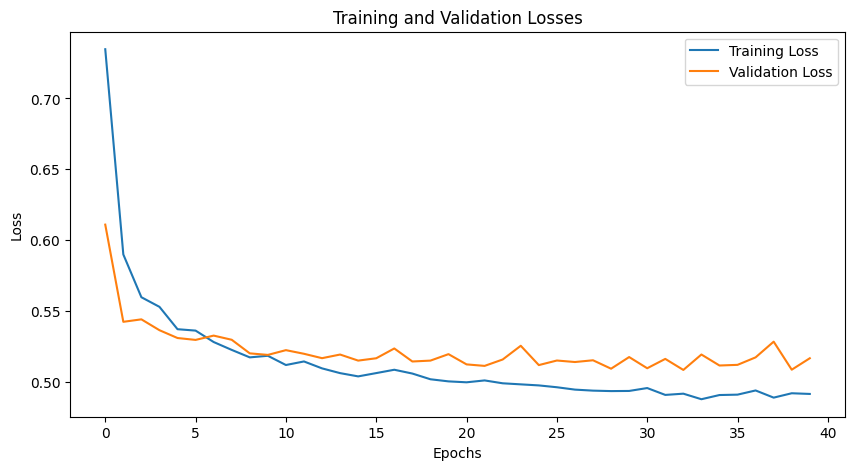

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [11]:
# Move test data tensor to the correct device
test_data_X_tensor = X_test_tensor.to(device)

# Prediction
net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = net(test_data_X_tensor)
    test_predictions = torch.sigmoid(test_outputs)  # Apply sigmoid to the logits to get probabilities
    test_predictions = test_predictions.round()  # Round probabilities to get binary class predictions

# Convert predictions to a NumPy array
test_predictions = test_predictions.cpu().numpy()

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    "PassengerId": test_passenger_id,
    "Transported": test_predictions.flatten().astype(bool)
})

# Save the DataFrame to a CSV file
submission_df.to_csv(r'C:\Users\liuch\Desktop\395\Final_Project\Spaceship_Titanic\spaceship-titanic\submission_cnn.csv', index=False)